# Страхование

**Основные задачи, решаемые в страховании**
* Классические задачи:
    * тарификация
    * антифрод
    * расчет комиссии посредников
* ML дало развитие задачам:
    * скоринг клиентов
    * оценка риска
    * оценка ущерба (резерва)
    * вероятность пролонгации
    * вероятность покупки опций
    * вероятность кросс-продаж
    * оценка параметров, неизвестных на начальном этапе (например, балл БКИ на предварительном расчете)
    * варианты развития убытка (вероятность отказа в выплате, вероятность суда, мошенничества)
    * распознавание марок-моделей ТС по фото
    * распознавание повреждений ТС по фото

**Риски, оцениваемые в автостраховании**
* Повреждения кузова
  * наш клиент виновен / невиновен
  * крупные / мелкие убытки
* Ущерб здоровью и жизни
* Обязательная гражданская ответственность (ОСАГО)
* Добровольная гражданская ответственность (ДАГО)
* Повреждения в результате действия третьих лиц
* Тоталь
* Угон
* Прочее

**Основная идея метода бустинга**
* Строится модель, прогнозирующая целевую переменную
* Находятся отклонения между прогнозными и фактическими значениями
* Отклонения - новая целевая переменная
* Строится модель, прогнозирующая отклонения
* Находятся новые отклонения после применения двух моделей
* Новые отклонения - снова целевая переменная
* ...

  ![](https://drive.google.com/uc?export=view&id=1S6rBG3Jn0nTww-X_Fs3h00F9OvkXHgUA)

**Особенности бустинга "деревянных" моделей**
* Бόльшая склонность к переобучению, чем у линейных моделей
* Требовательность к подбору гиперпараметров
* Сложность с трактовкой значимости параметров

**Схема решающего дерева для задачи классификации**

  ![](https://drive.google.com/uc?export=view&id=1WlLe4akj2-8LsEeWoS8lCDzATkMKzcO1)



Основная мера неоднородности при построении деревьев - энтропия Шеннона
  ![](https://drive.google.com/uc?export=view&id=16FWKv29X4qFkvi8W0MMN9rkOm4TFByq8) ,
где p - вероятность состояния, i - состояние системы. Чем выше энтропия, тем больше хаоса.

  ![](https://drive.google.com/uc?export=view&id=1Dl9u-uwnpBn6a4ORFBXrXMFMDrbBjLtH)

  ![](https://drive.google.com/uc?export=view&id=1f77y84obWiPmX2W57N5cdm4RlVQCz3wf)

  ![](https://drive.google.com/uc?export=view&id=1amL7hYh0D3LEJQt0Ntr1JdqClEgNDODV)

 Прирост информации (изменение энтропии)
  ![](https://drive.google.com/uc?export=view&id=1LPgPB2aSvvhVYa2qD3Kgy-XTD-2oVx5G)

**Алгоритм построения решающих деревьев**
* Вычисляем энтропию исходного множества
* Если энтропия равна 0, значит все объекты принадлежат к одному классу
* Разбиваем исходное множество на два подмножества, вычисляем изменение энтропии
* Среди всех возможных разбиений выбираем то, у которого изменение энтропии наибольшее
* Повторяем процесс: разбиваем каждое из полученных подмножеств

  ![](https://drive.google.com/uc?export=view&id=1Q-qEQLZ-sjPQrei-EBxpmBS9yfZTKU2o)

**Для задачи регрессии**
* Мера неоднородности - это ошибка на выборке

**Градиентный спуск**
* Поиск минимума ошибки за счет движения в сторону антиградиента

**Что работает лучше, деревья решений или линейные модели?**
* Ответ зависит от ситуации с данными
* В страховых задачах оценки риска преимущество "деревянных" моделей неочевидно

# Решение задачи оценки ожидаемых выплат по полису КАСКО методом градиентного бустинга

# Предобработка данных

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings = 'ignore'

## Специфические преобразования

In [4]:
PATH = '/content/drive/MyDrive/geekbrain/ML Buisness/'

In [5]:
# Загрузим набор данных

df = pd.read_csv(PATH+'freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Есть отрицательная величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [6]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [7]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [8]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,NaN,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,NaN,Female,Other,CSP55,Private+trip to office,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [9]:
df.columns

Index(['Exposure', 'LicAge', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat',
       'SocioCateg', 'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'ClaimNbResp', 'ClaimNbNonResp',
       'ClaimNbParking', 'ClaimNbFireTheft', 'ClaimNbWindscreen', 'OutUseNb',
       'RiskArea'],
      dtype='object')

In [10]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [11]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


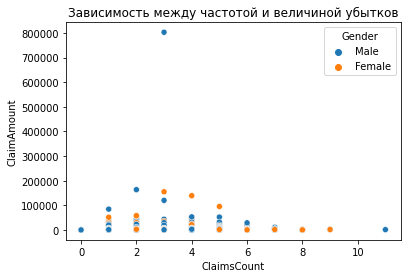

In [12]:

sns.scatterplot( x = df['ClaimsCount'],y = df['ClaimAmount'], hue = df.Gender)
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

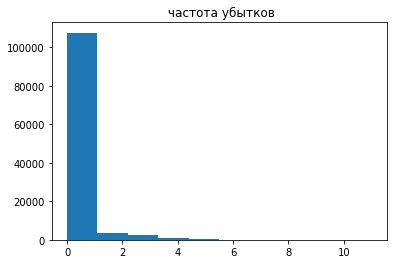

In [13]:
plt.hist(df['ClaimsCount'], bins=10)
plt.title(' частотa убытков')
plt.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [14]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

## Общие преобразования

Класс для общих случаев

In [15]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [16]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

Подгружаем данные

In [17]:
data = InsDataFrame_Fr()

In [18]:
data.load_pd(df)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   RecordBeg    115155 non-null  object 
 3   RecordEnd    59455 non-null   object 
 4   Gender       115155 non-null  object 
 5   MariStat     115155 non-null  object 
 6   SocioCateg   115155 non-null  object 
 7   VehUsage     115155 non-null  object 
 8   DrivAge      115155 non-null  int64  
 9   HasKmLimit   115155 non-null  int64  
 10  BonusMalus   115155 non-null  int64  
 11  ClaimAmount  115155 non-null  float64
 12  ClaimInd     115155 non-null  int64  
 13  OutUseNb     115155 non-null  float64
 14  RiskArea     115155 non-null  float64
 15  ClaimsCount  115155 non-null  float64
 16  AvgClaim     10869 non-null   float64
dtypes: float64(6), int64(5), object(6)
memory usage: 14.9+ MB


Преобразовываем параметры

In [20]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [21]:
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

In [22]:
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

Для переменных, содержащих более 2 значений:
- либо упорядочиваем значения,
- либо используем фиктивные переменные (one-hot encoding).

In [23]:
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [25]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

In [26]:
col_features1 = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
    
]

In [27]:
col_features=col_features1

In [28]:
col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

In [29]:
df_freq = data.get_pd(col_features+col_target)

In [30]:
df_ac = df_freq[df_freq['ClaimsCount'] > 0].reset_index().copy()

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df_freq[col_features], df_freq.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [33]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(df_ac[col_features], df_ac.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

# Градиентный бустинг

Градиентный бустинг - ансамблевый метод машинного обучения, использующийся для задач классификации, регрессии и ранжирования. Ансамбль представляет собой композицию простых базовых алгоритмов, в качестве которых обычно используются деревья решений. 

Классический алгоритм GBM был предложен [Джеромом Фридманом в
1999 году](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). Популярность методов GBM пришла в 2015-2016 гг. благодаря большому
успеху библиотеки XGBoost в соревнованиях Kaggle.

Популярные библиотеки для GBM:
* XGBoost (eXtreme Gradient Boosting)
    * скорость, масштабируемость, поддержка распределенных вычислений
    * добавление компоненты регуляризации, отсутствовавшей в классическом алгоритме GBM
* LightGBM
    * использование алгоритмов, основанных на гистограммах, которые позволяют сократить время исполнения и потребление памяти в процессе обучения моделей. 
* CatBoost (Categorical Boosting)
    * предназначается для эффективной работы с категориальными признаками

Все перечисленные библиотеки зачастую имеют сравнимый результат.

### Теория (XGBoost)

**Модель**

Пусть $y_i$ – значение переменной, которое необходимо предсказать, $x_i$ – входные данные.

Модель имеет вид
$$\hat{y}_i = \sum_{k=1}^K f_k(x_i),\hspace{10pt} f_k \in \mathcal{F},$$
где $K$ – количество деревьев, $f$ – функция на пространстве $\mathcal{F}$, которое содержит все возможные деревья решений.

**Целевая функция**
$$\text{Obj}(\theta) = L(\theta) + \Omega(\theta),$$
где 
* $\theta$ – параметры модели;
* $L$ – величина потерь на обучающей выборке  (насколько хорошо модель описывает данные?);
* $\Omega$ – компонента, отвечающая за регуляризацию (насколько модель сложная?).

Тогда для представленной модели $\theta = \{f_1,f_2,\cdots,f_K\}$,

$$\text{Obj} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K\Omega(f_k),$$
где $l(y_i, \hat{y}_i)$ – функция потерь.

**Обучение**

Необходимо обучить функции $f_i$, каждая из которых включает структуру дерева и значения листьев.

Обозначим $\hat{y}_i^{(t)}$ предсказанное значение на шаге $t$. Тогда целевая функция имеет вид:
$$\text{Obj} = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i).$$

Обучение деревьев происходит поочередно, начиная с постоянного предсказания:
$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

На каждом шаге выбирается дерево, которое оптимизирует целевую функцию.
$$\begin{split}\text{Obj}^{(t)} & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t) + \mathrm{constant}\end{split}$$


Для упрощения задачи оптимизации для заданной функции потерь используется разложение Тейлора:
$$F(x+\Delta x) \simeq F(x) + F'(x)\Delta x + \frac{1}{2} F''(x)\Delta x^2 + \dots$$

Тогда обозначив градиент и гессиан функции потерь соответственно
$$g_i = \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)}),\hspace{10pt}h_i = \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)}),$$
целевая функция будет иметь вид
$$\text{Obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}.$$

Убирая константы на шаге $t$, целевая функция упрощается в виде:
$$\text{Obj}^{(t)} = \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t).$$

Таким образом, величина потерь $L$ зависит только от $g_i$ и $h_i$.

Благодаря этому, XGBoost поддерживает пользовательские целевые функции, для которых достаточно задать градиент и гессиан функции потерь.

**Регуляризация**

Для начала определим дерево $f_t(x)$:
$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\},$$
где $w$ – вектор значений на листьях дерева, $T$ – количество листьев, $q$ – функция, которая каждой точке набора данных ставит в соответствие лист дерева.

Тогда сложность модели имеет вид
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2+ \alpha \sum_{j=1}^T |w_j|,$$
где $\gamma$ – штраф на сложность деревьев, $\lambda$ – сила регуляризации $\ell_2$, $\alpha$ – сила регуляризации $\ell_1$.

**Переобучение**
Для контроля переобучения помимо параметров $\gamma$, $\alpha$ и $\lambda$ используются также параметры:
* Контролирующие сложность модели напрямую 
    * максимальная глубина дерева (`max_depth`)
    * минимальный вес в узле, ниже которого прекращается дальнейшее разделение в этом узле (`min_child_weight`)
* Добавляющие случайность, повышая устойчивость к зашумлению
    * $\eta$ – величина шага. $\eta \in (0,1]$.
    Вместо $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$ используется 
    $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta\cdot f_t(x_i)$
    * Доля подвыборки наблюдений для построения деревьев (`subsample`)
    * Доля подвыборки признаков для построения деревьев (`colsample_bytree`)

Теория, стоящая за оценкой весов на листьях и нахождением разделений выходит за рамки нашего рассмотрения.

* [Chen, Tianqi, and Carlos Guestrin. "Xgboost: A scalable tree boosting system." ](https://arxiv.org/pdf/1603.02754.pdf)
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [А. Дьяконов «Введение в анализ данных и машинное обучение». Градиентный бустинг](https://alexanderdyakonov.files.wordpress.com/2017/06/book_boosting_pdf.pdf)
* [Rokach, Lior. Ensemble Learning: Pattern Classification Using Ensemble Methods (Second Edition)](https://books.google.ru/books/about/Ensemble_Learning_Pattern_Classification.html?id=_AmMDwAAQBAJ&redir_esc=y)

### Выбор гиперпараметров

Основные гиперпараметры, используемые в библиотеке XGBoost
* _objective_ - функция распределения
* _eta_ - размер шага
* _max_depth_ - максимальная глубина дерева
* _min_child_weight_ - минимальный вес, необходимый дочерним элементам
* _subsample_ - доля подвыборки для каждой итерации
* _colsample_bytree_ - доля колонок, участвующих в итерации
* _alpha_ - сила регуляризации L1
* _lambda_ - сила регуляризации L2
* _gamma_ - штраф на сложность деревьев
* _num_boost_round_ - число итераций (фиксируем, не следует менять вместе с _eta_)
* _early_stopping_rounds_ - число итераций для остановки, если не произошло улучшение метрики (фиксируем) 

Стратегии подбора гиперпараметров:
* Поиск на сетке (Grid Search, Randomized Search)
* Покоординатный спуск (Coordinate Descent)
* Генетические алгоритмы (Genetic Algorithms)
* Байесовская оптимизация
* ...

[Использование некоторых алгоритмов подбора гиперпараметров для  XGBoost](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)

Для подбора параметров воспользуемся реализацией алгоритма Tree-structured Parzen Estimator (TPE) в библиотеке `Hyperopt`. Алгоритм использует подход последовательной оптимизации, основанной на модели (sequential model-based optimization, SMBO). Метод основывается в байесовской оптимизации и гауссовских процессах.

* [Bergstra, James S., et al. "Algorithms for hyper-parameter optimization." Advances in neural information processing systems. 2011.](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

In [34]:
#!pip install hyperopt --upgrade

     |████████████████████████████████| 972kB 14.9MB/s 
  Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2


In [35]:
from functools import partial
import xgboost as xgb
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK

### Построение модели градиентного бустинга для частоты страховых случаев

In [36]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_c = xgb.DMatrix(x_train_c, y_train_c)
valid_c = xgb.DMatrix(x_valid_c, y_valid_c)
test_c = xgb.DMatrix(x_test_c, y_test_c)

In [37]:

# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, y):
    t_hat, t = yhat + 1, y.get_label() + 1
    return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))

In [38]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [39]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_poisson,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [40]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'objective': 'count:poisson',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
           
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }

In [41]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_c),
            space=space_freq, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

100%|██████████| 50/50 [09:54<00:00, 11.88s/trial, best loss: 0.6541374000000001]


In [42]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.3612829123684997,
 'colsample_bytree': 0.6760539548453088,
 'eta': 0.04764656832026267,
 'lambda': 0.6517872836669781,
 'max_depth': 5,
 'min_child_weight': 34.46028966728921,
 'objective': 'count:poisson',
 'subsample': 0.6875264418054632,
 'tree_method': 'hist'}

In [43]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_poisson,
                'maximize': False,
                'verbose_eval': False}

In [44]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = xgb.train(params=best_params, dtrain=train_c, early_stopping_rounds=10,
                     evals=[(train_c, "train"), (valid_c, "valid")],
                     evals_result=progress, **train_params)

In [45]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_freq_wo_es = xgb.train(params=best_params, dtrain=train_c, evals=[(train_c, "train"), (valid_c, "valid"), (test_c, "test")],
                           evals_result=progress_wo_es, **train_params)

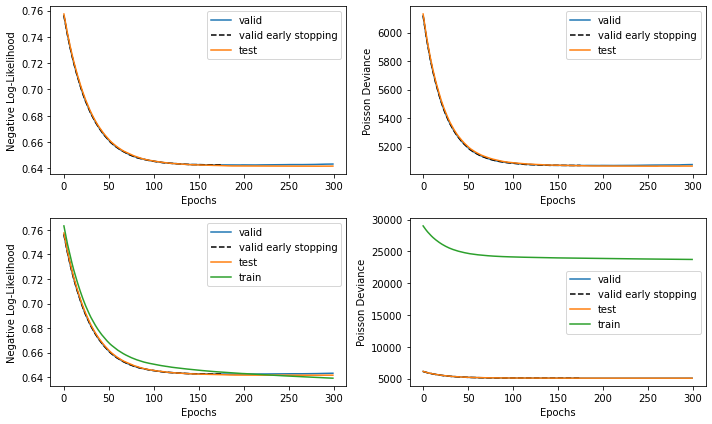

In [46]:
import matplotlib.pyplot as plt
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.plot(progress_wo_es['train']['poisson-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.plot(progress_wo_es['train']['dev_poisson'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout(); plt.show()

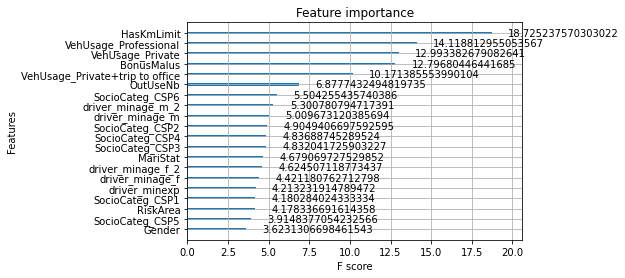

In [47]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[1]); plt.show()

### Построение модели градиентного бустинга для среднего убытка

In [48]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_ac = xgb.DMatrix(x_train_ac, y_train_ac)
valid_ac = xgb.DMatrix(x_valid_ac, y_valid_ac)
test_ac = xgb.DMatrix(x_test_ac, y_test_ac)

In [49]:
# Зададим функцию Deviance для гамма-распределения

def xgb_eval_dev_gamma(yhat, dtrain):
    y = dtrain.get_label()
    return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)

In [50]:
# Определим границы, в которых будем искать гиперпараметры 

space_avgclm = {'objective': 'reg:gamma',
                'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
                'min_child_weight': hp.uniform('min_child_weight', 0, 50),
                'subsample': hp.uniform('subsample', 0.5, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                'alpha': hp.uniform('alpha', 0, 1),
                'lambda': hp.uniform('lambda', 0, 1),
                'eta': hp.uniform('eta', 0.01, 1),
                'tree_method': 'hist'
                }        

In [51]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_gamma,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [52]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_ac),
            space=space_avgclm, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

100%|██████████| 50/50 [01:22<00:00,  1.65s/trial, best loss: 8.0436092]


In [53]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_avgclm, best)
best_params

{'alpha': 0.9883029577090331,
 'colsample_bytree': 0.5072640639787005,
 'eta': 0.5635559233780751,
 'lambda': 0.10838822629314249,
 'max_depth': 5,
 'min_child_weight': 18.868733429635792,
 'objective': 'reg:gamma',
 'subsample': 0.960451065757381,
 'tree_method': 'hist'}

In [54]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_gamma,
                'maximize': False,
                'verbose_eval': False}

In [55]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_avgclaim = xgb.train(params=best_params, dtrain=train_ac, early_stopping_rounds=10, evals=[(train_ac, "train"), (valid_ac, "valid")],
                         evals_result=progress, **train_params)

In [56]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_avgclaim_wo_es = xgb.train(params=best_params, dtrain=train_ac, evals=[(train_ac, "train"), (valid_ac, "valid"), (test_ac, "test")],
                               evals_result=progress_wo_es, **train_params)

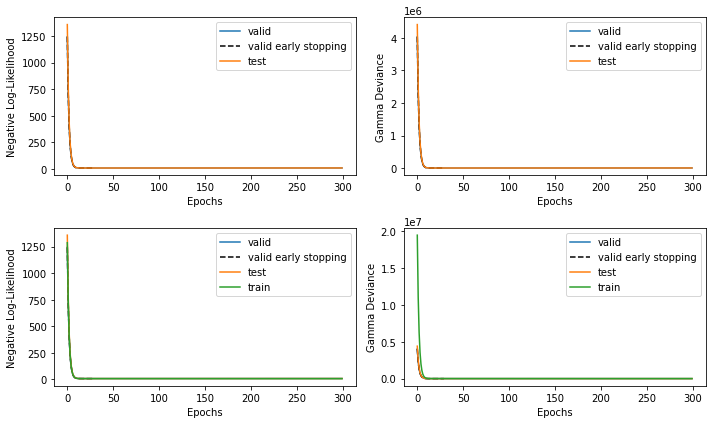

In [57]:
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.plot(progress_wo_es['train']['gamma-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.plot(progress_wo_es['train']['dev_gamma'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout(); plt.show()

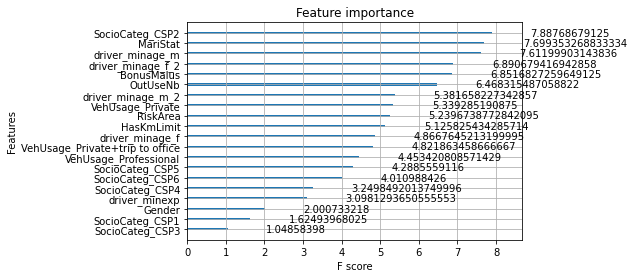

In [58]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_avgclaim, importance_type=importance_type[1]); plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

## **Прогноз убытков : оценка страхового тарифа**

Оценим средний убыток на страховой случай клиента

In [59]:
y_ac = xgb_avgclaim.predict(test_ac) 

Оценим среденее числдо страховых случаев на клиента

In [62]:
y_c = xgb_freq.predict(test_ac)

In [63]:
y_ = y_ac * y_c 


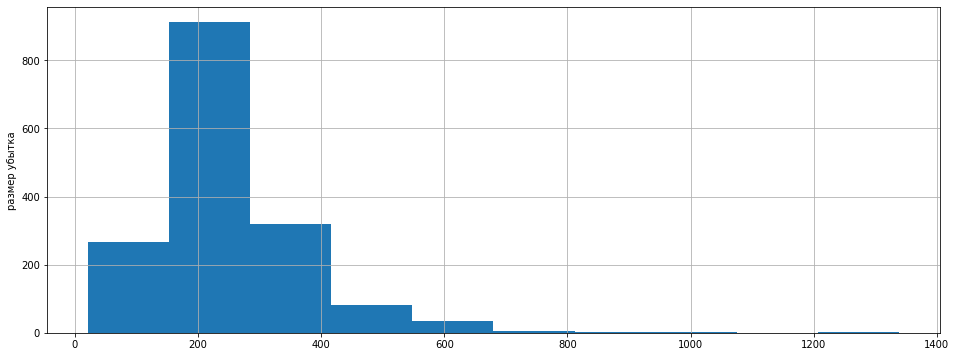

In [67]:
plt.figure(figsize = (16,6))
plt.grid('On')
plt.hist(y_)
plt.ylabel('число клиентов')
plt.ylabel('размер убытка')
plt.title(' количество клиентов по полному убытку')
plt.show()